In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from IPython import display

# common model algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

# common model helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# visiualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

import warnings
warnings.filterwarnings('ignore')

import time

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

**Load Data**

In [2]:
# import training and test set
data_raw = pd.read_csv('../train.csv')
data_val = pd.read_csv('../test.csv')

# Make a copy of the training set to wrangle
data1 = data_raw.copy(deep=True)

# Put both in a list so we can clean both datasets at once
data_cleaner = [data1, data_val]

# Get an overview of the data
print(data_raw.info())
data1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Get overview of data and missing values**

In [3]:
# Check for null values in training and test set
print('Training set null values\n', data1.isnull().sum())
print('-'*20)
print('Test set null values\n', data_val.isnull().sum())

Training set null values
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
Test set null values
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


test df null values: Age, Cabin and Embarked<br>
training df null values: Age, Fare, Cabin

In [4]:
# Check for outliers / weird values
data_raw.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Hendekovic, Mr. Ignjac",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## Complete Data

**Data to Complete**<br>
Age: Use median to compute missing values<br>
Embarked: Use mode to complete missing values<br>
Fare: Use median to complete missing fare

**Data to Drop**<br>
Cabin: Too many missing values, furthermore doesnt make sense to use this as a predictor for survival rate

In [5]:
# Complete data for both training and test sets
for dataset in data_cleaner:
    dataset['Age'].fillna(value=dataset['Age'].median(), inplace=True)
    dataset['Embarked'].fillna(value=dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(value=dataset['Fare'].median(), inplace=True)

# drop columns in test set
drop_columns = ['PassengerId', 'Cabin', 'Ticket']
data1.drop(drop_columns, axis=1, inplace=True)

# check if data completed for both training and test set
print(data1.isnull().sum())
print('-'*20)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


## Create (Feature Engineering)

**New Features To Create**<br>
FamilySize: Parch + Sibsp + 1<br>
IsAlone: 1 if alone else 0 if there are siblings<br>
Title feature: Take out the titles from the names to see if people who have titles have higher chance of survival<br>

**Numerical features that can be converted to categorial**<br>
FareBin: Cut Fare into 4 equal bins<br>
AgeBin: Cut Age into 5 bins 

In [6]:
# Create new features in both the training and test set

for dataset in data_cleaner:
    # Create feature for FamilySize
    dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp'] + 1
    
    # Create feature for IsAlone. 1 for alone, 0 if there have siblings or children
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    
    # Create Title feature
    dataset['Title'] = dataset['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    
    # Create Age Bins
    dataset['AgeBin'] = pd.cut(dataset['Age'], 5)
    
    # Create Fare Bins
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

In [7]:
data1.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(16.336, 32.252]","(-0.001, 7.91]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(32.252, 48.168]","(31.0, 512.329]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(16.336, 32.252]","(7.91, 14.454]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(32.252, 48.168]","(31.0, 512.329]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(32.252, 48.168]","(7.91, 14.454]"


In [8]:
# Replace wrong designations
data1['Title'] = data1['Title'].replace({'Ms': 'Miss', 'Mme': 'Mrs', 'Mlle':'Miss'})

# Group uncommon designations as misc
stat_min = 10
title_names = data1['Title'].value_counts() < stat_min

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())

Mr        517
Miss      185
Mrs       126
Master     40
Misc       23
Name: Title, dtype: int64


## Convert Features 

Convert text data to ordinal (LabelEncoder), then convert to OneHot (pd.get_dummies)

**Categorical Data**: Sex, Pclass, Embarked, Title, SibSp, Parch, Age, Fare,FamilySize, FamilySize, IsAlone

In [9]:
data1.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,AgeBin,FareBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(16.336, 32.252]","(-0.001, 7.91]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(32.252, 48.168]","(31.0, 512.329]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(16.336, 32.252]","(7.91, 14.454]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(32.252, 48.168]","(31.0, 512.329]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(32.252, 48.168]","(7.91, 14.454]"


In [10]:
# code categorical data
label = LabelEncoder()

for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
# define y variable for target/outcome
Target = ['Survived']

# define x variable for original features aka feature selection
data1_x = ['Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']

# pretty name/values for charts
data1_x_calc = ['Sex', 'Pclass', 'Embarked_Code', 'Title_Code', 'SibSp', 'Parch', 'Age', 'Fare'] # coded for algo calc

data1_xy = Target + data1_x
print('Original X Y: ',data1_xy,'\n' )


# define x variables for original with bin features. Categorical coded numerically instead of in words.
data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


# Establish dummy variables
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [11]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 21 columns):
PassengerId      418 non-null int64
Pclass           418 non-null int64
Name             418 non-null object
Sex              418 non-null object
Age              418 non-null float64
SibSp            418 non-null int64
Parch            418 non-null int64
Ticket           418 non-null object
Fare             418 non-null float64
Cabin            91 non-null object
Embarked         418 non-null object
FamilySize       418 non-null int64
IsAlone          418 non-null int64
Title            418 non-null object
AgeBin           418 non-null category
FareBin          418 non-null category
Sex_Code         418 non-null int64
Embarked_Code    418 non-null int64
Title_Code       418 non-null int64
AgeBin_Code      418 non-null int64
FareBin_Code     418 non-null int64
dtypes: category(2), float64(2), int64(11), object(6)
memory usage: 63.1+ KB


## Split data into training and test set

In [12]:
# Split data into training and test set
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state=0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state=0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state=0)

print('Data1 Shape:', data1.shape)
print('Train1 Shape:', train1_x.shape)
print('Test1 Shape:', test1_x.shape)

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


## Perform exploratory analysis with statistics

Create a pivot table to observe each predictor's correlation with the Target (survival)

In [13]:
# Discrete variable correlation by survival using groupby pivot table
for x in data1_x:
    if data1[x].dtype != 'float64':
        print('Survival Correlation by: ', x)
        print(data1[[x, Target[0]]].groupby(by=x, as_index=False).mean())
        print('-'*40,'\n')
#         print(pd.crosstab(data1[x], data1[Target[0]]))
#         print('-'*40,'\n')
        
# Using crosstabs
print(pd.crosstab(data1['Title'], data1[Target[0]]))

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------------------------------- 

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------------------------------- 

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------------------------------- 

Survival Correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.347826
2    Miss  0.702703
3      Mr  0.156673
4     Mrs  0.793651
---------------------------------------- 

Survival Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------------------------------------- 

Survival Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000


## Plot numerical continuous variables

Look at distribution of numerical continuous variables

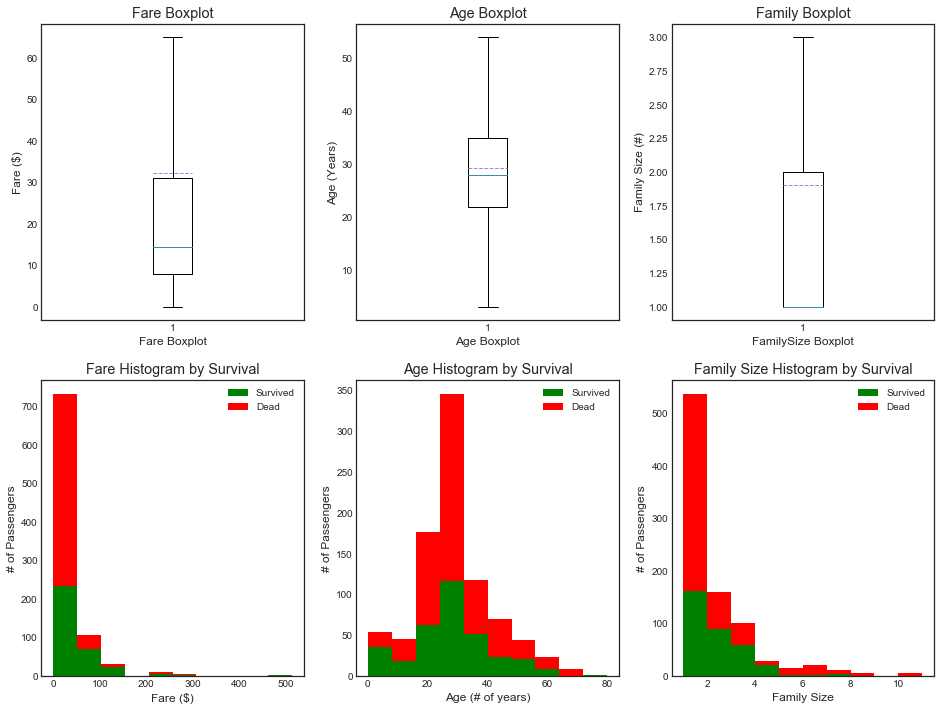

In [14]:
plt.figure(figsize=(16,12))
0
plt.subplot(231)
plt.boxplot(data1['Fare'], sym='', meanline=True, showmeans=True);
plt.xlabel('Fare Boxplot')
plt.ylabel('Fare ($)')
plt.title('Fare Boxplot')

plt.subplot(232)
plt.boxplot(data1['Age'], sym='', meanline=True, showmeans=True);
plt.xlabel('Age Boxplot')
plt.ylabel('Age (Years)')
plt.title('Age Boxplot')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], sym='',  meanline=True, showmeans=True);
plt.xlabel('FamilySize Boxplot')
plt.ylabel('Family Size (#)')
plt.title('Family Boxplot')

plt.subplot(234)
plt.hist(x=[data1[data1['Survived'] == 1]['Fare'], data1[data1['Survived'] == 0]['Fare']], stacked=True, color=['g', 'r'], label=['Survived', 'Dead'])
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.title('Fare Histogram by Survival')
plt.legend()

plt.subplot(235)
plt.hist(x=[data1[data1['Survived'] == 1]['Age'], data1[data1['Survived'] == 0]['Age']], stacked=True, color=['g', 'r'], label=['Survived', 'Dead'])
plt.xlabel('Age (# of years)')
plt.ylabel('# of Passengers')
plt.title('Age Histogram by Survival')
plt.legend()

plt.subplot(236)
plt.hist(x=[data1[data1['Survived'] == 1]['FamilySize'], data1[data1['Survived'] == 0]['FamilySize']], stacked=True, color=['g', 'r'], label=['Survived', 'Dead'])
plt.xlabel('Family Size')
plt.ylabel('# of Passengers')
plt.title('Family Size Histogram by Survival')
plt.legend();

## Plot categorical features

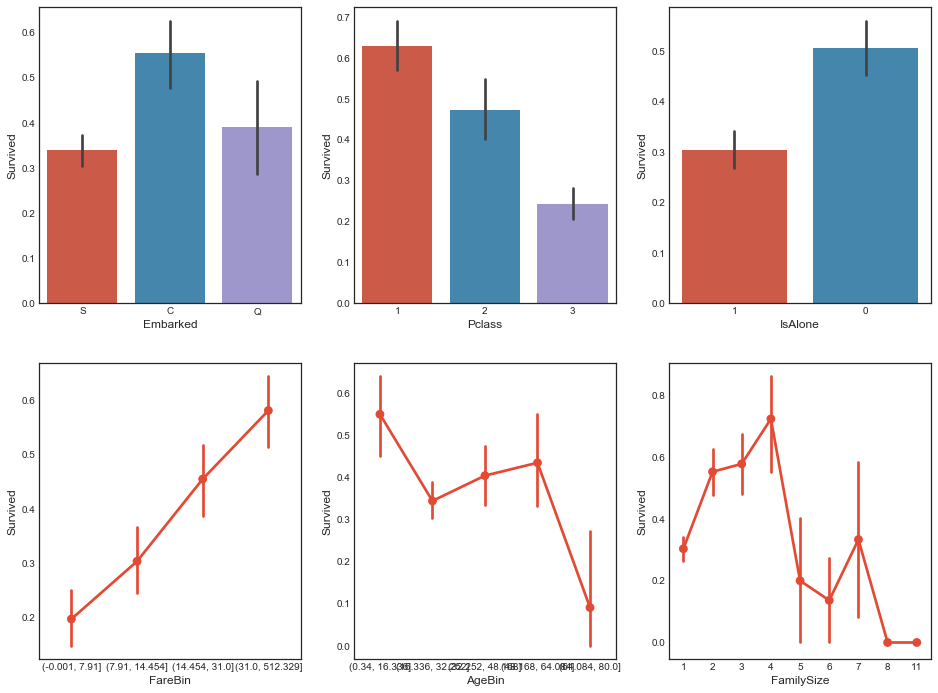

In [15]:
fig, saxis = plt.subplots(2,3,figsize=(16,12))

sns.barplot(x= 'Embarked', y= 'Survived', data=data1, ax= saxis[0,0])
sns.barplot(x = 'Pclass', y='Survived', data=data1, ax=saxis[0,1])
sns.barplot(x = 'IsAlone', y='Survived', data=data1, ax=saxis[0,2], order=[1,0])

sns.pointplot(x='FareBin', y='Survived', data=data1, ax=saxis[1,0])
sns.pointplot(x='AgeBin', y='Survived', data=data1, ax=saxis[1,1])
sns.pointplot(x='FamilySize', y='Survived', data=data1, ax=saxis[1,2])

- Passegers from port C had a significantly higher chance of survival
- May be multicollinearity, where passengers who had higher fare / class boarding from port C
- Passengers from better class higher chance of survival
- Passengers who were not alone had a higher chance of survival<br><br>

- Passengers who paid higher fares had higher chance of survival. Again, may be multicollinearity between Fare and PClass

## Graph distribution of Pclass w.r.t other variables (fare, age, family size)

Text(0.5,1,'Pclass vs Family Size Survival Comparison')

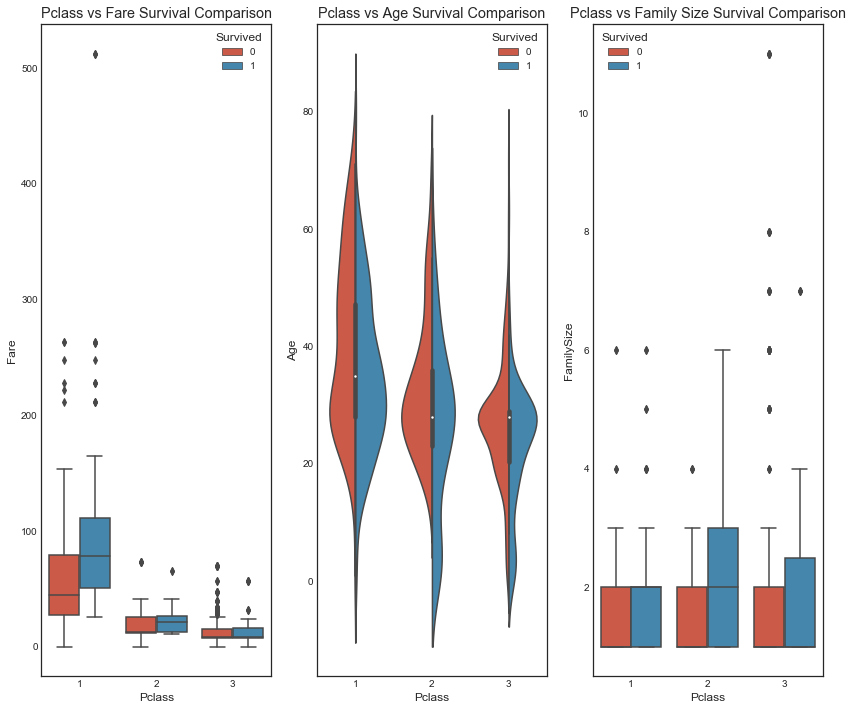

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,12))

sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=data1, ax=ax1)
ax1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x='Pclass', y='Age', hue='Survived', data=data1, ax=ax2, split=True)
ax2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x='Pclass', y='FamilySize', hue='Survived', data=data1, ax=ax3)
ax3.set_title('Pclass vs Family Size Survival Comparison')

- Passengers from higher classes paid a higher fare
- Passengers who are older tend to be from higher classes
- No clear relationship between FamilySize and PClass

## Graph Distribution of  Sex Variable

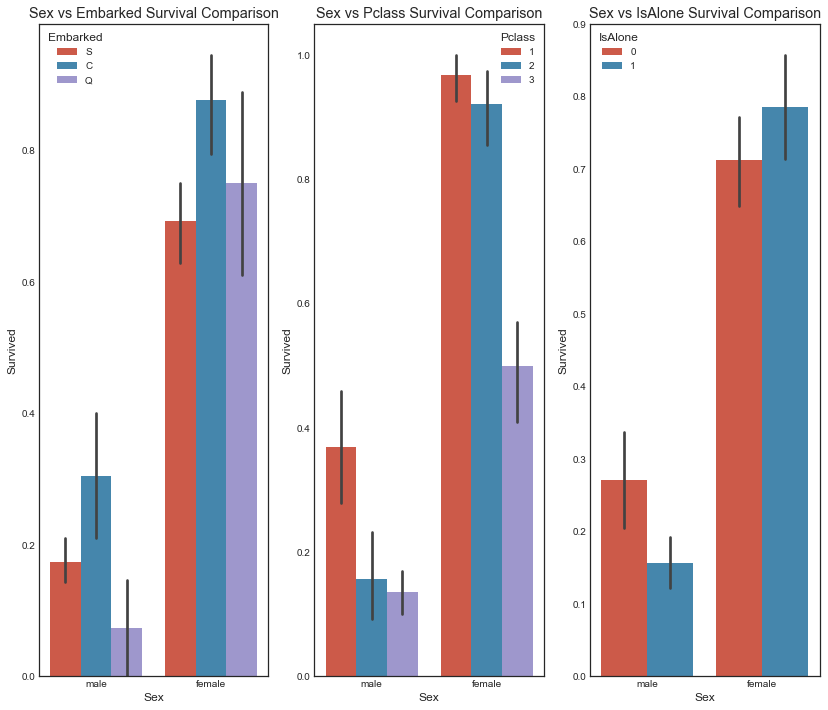

In [17]:
# graph distribution of qualitative data: sex

fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax = qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax = qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comparison');

- Obvious that females had a much higher chance of survival as compared to males

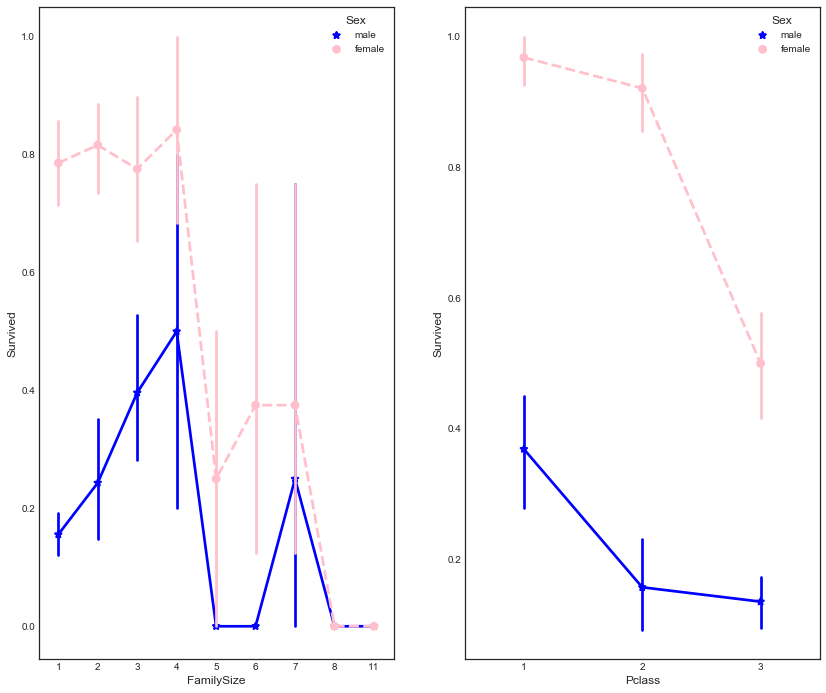

In [18]:
# More side by side comparisons of FamilySize and Pclass vs the dependent variable

fig, (maxis1, maxis2) = plt.subplots(1,2,figsize=(14,12))

# family size with survival and sex compare
sns.pointplot(x='FamilySize', y='Survived', hue='Sex', data=data1, ax=maxis1, palette={'male': 'blue', 'female': 'pink'},
             markers=['*', 'o'], linestyles=['-', '--'])

# Pclass with survival and sex compare
sns.pointplot(x='Pclass', y='Survived', hue='Sex', data=data1, ax=maxis2, palette={'male': 'blue', 'female': 'pink'},
             markers=['*', 'o'], linestyles=['-', '--']);

- Again clear that females have higher chance of survival
- No clear relationship between FamilySize and Survival
- Clear relationship between PClass and survival

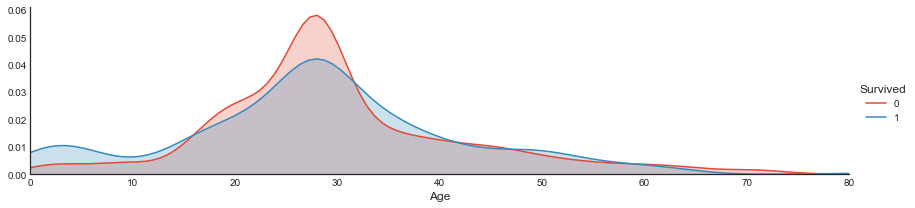

In [19]:
# Plot distribution of passengers who survived vs died
a = sns.FacetGrid(data1, hue='Survived', aspect=4)
a.map(sns.kdeplot, 'Age', shade=True)
a.set(xlim=(0, data1['Age'].max()))
a.add_legend()

- Higher proportion of young children (below 15) survived - More survived than died
- Lower proportion of middle aged (20 - 35) survived - More died than survived
- Above 35, about equal percentages survived and died

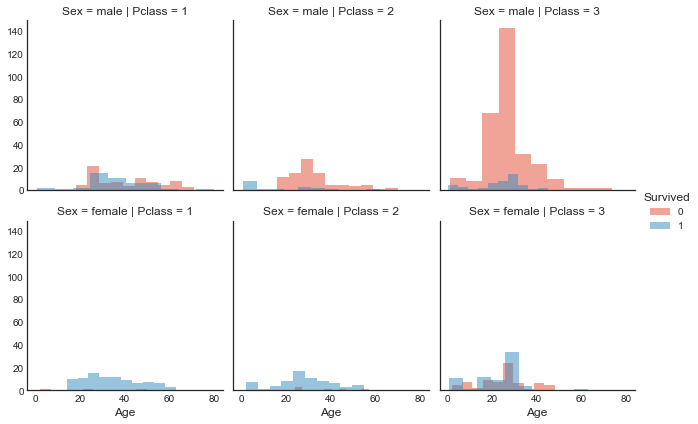

In [20]:
# Comparison of Sex, Class, and Age
s = sns.FacetGrid(data1, row='Sex', col='Pclass', hue='Survived')
s.map(plt.hist, 'Age', alpha=0.5)
s.add_legend()

- We can see that the vast proportion of those who died are **males from 2nd and 3rd class**
- Almost all females from the 1st and 2nd classes survived

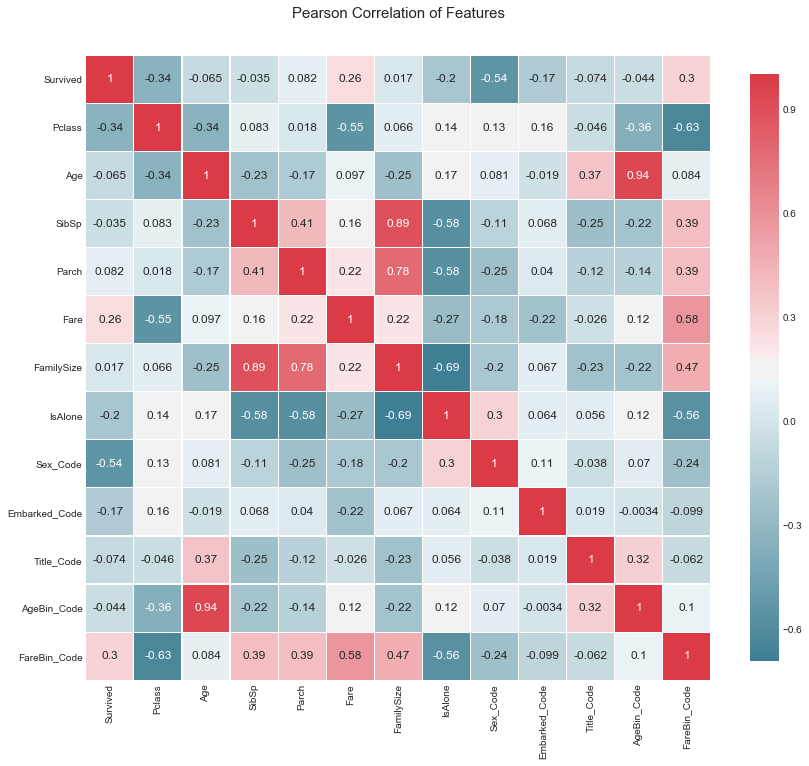

In [21]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

Corr heatmaps shows the following:
- Strong negative correlation between PClass and FareBin (higher fare, lower the class)
- Strong negative correlation between FareBin_Code and IsAlone
- As noted earlier, strong correlation between Sex and Survived
- As noted earlier, moderate negative correlation between PClass and Survived
- Modete positive correlation between Title and Age. Makes sense

Of course, strong correlation between the below features as they were engineered:
- SibSp and Parch and the additional features that we derived from them: Family Size and IsAlone
- 

# Model Data

Create a table with all the base models, evaluating the CV train and test accuracy, as well as the standard deviation

In [22]:
# Machine Learning Algo Selection and Initialization
MLA = [
    # Ensemble methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    # Gaussian Process
    gaussian_process.GaussianProcessClassifier(),
    
    #General Linear Models
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # Nearest Neighbour
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    # Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    # XGBoost
    XGBClassifier()
]

# Split dataset in cross-validation with sklearn shuffle split. This is an alternative to train_test_split
# run the model 10x, with a train/test split of 60/30, intentionally leaving out 10%
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=0)

# Create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns=MLA_columns)

# Create table to compare MLA predictions
MLA_predict = data1[Target]

# loop through MLA and save performance in the table
row_index = 0
for alg in MLA:
    
    # Set names and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    # Score model with cross validation
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv=cv_split)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    # Find std, and if this is non-bias random sample, +/- 3 stdev from mean should statistically
    # capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    # Fit and predict for each MLA and save in df
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index += 1
    
# Print and sort table
MLA_compare.sort_values(by=['MLA Test Accuracy Mean'], ascending=False, inplace=True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.855056,0.826866,0.0483292,0.0200663
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0424614
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835393,0.823507,0.0485491,0.0453207
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866854,0.822761,0.051114,0.0709948
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.822015,0.0559813,0.00190728
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.890075,0.820896,0.0522655,0.0182543
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.819403,0.0631645,0.0143246
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891948,0.81903,0.0717205,0.0150622
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.851685,0.815672,0.0666397,0.00210695
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.814179,0.0674992,0.00189352


Plot the results of each classifier to see which one has the highest Test Accuracy

In [25]:
# svm_model = svm.SVC(probability=True)
# svm_model.fit(train1_x_dummy, train1_y_dummy)


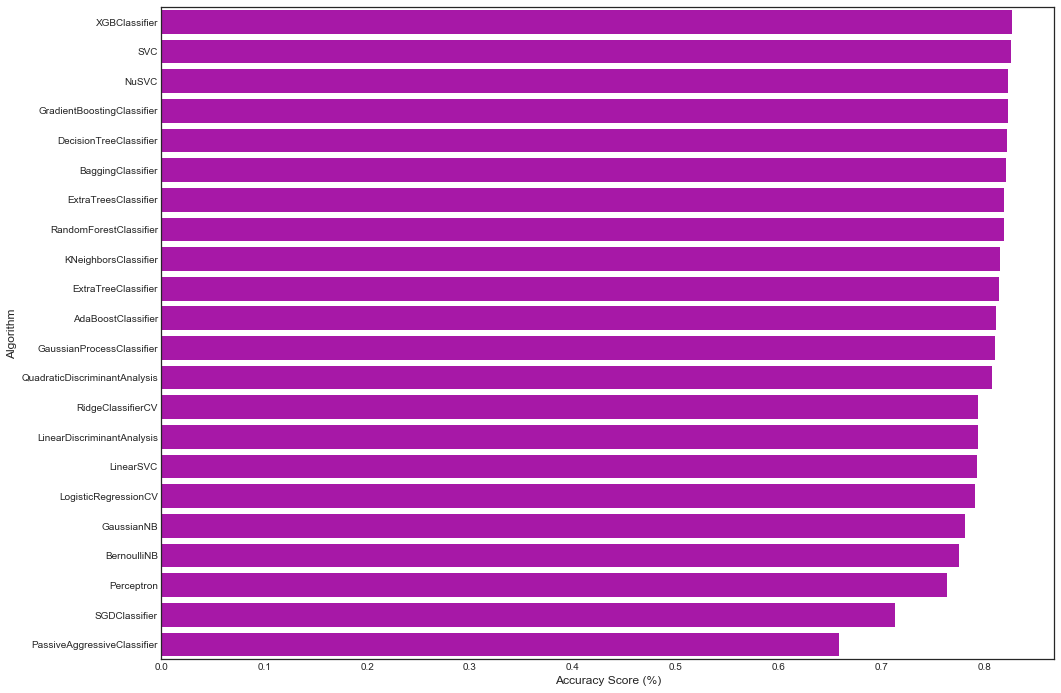

In [23]:
# Plot results of each classifier
plt.figure(figsize=(16,12))
sns.barplot(x='MLA Test Accuracy Mean', y='MLA Name', data=MLA_compare, color='m')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm');

# Tune Models


**Tune model's hyper parameters**<br>
Use ParameterGrid to get all possible combinations parameters, and then GridSearchCV. Evaluate it using sklearn scoring, ROC_AUC scores

In [40]:
# Intialise base model
dtree = tree.DecisionTreeClassifier(random_state=0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target], cv=cv_split)
dtree.fit(data1[data1_x_bin], data1[Target])

print('Before DT Parameters', dtree.get_params())
print('Before DT Training w/bin score mean: {:.2f}'.format(base_results['train_score'].mean()*100) )
print('Before DT Test w/bin score mean: {:.2f}'.format(base_results['test_score'].mean()*100))
print('Before DT Test w/bin score 3*std: +/- {:.2f}'.format(base_results['test_score'].std()*100*3))
print('-'*60)

# Tune hyper parameters
# Use Gridsearch to get run all permutations of the hyper parameters. Put permutations in dict first
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[2,4,6,8,10,None], 'random_state': [0]}

tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=cv_split)
tune_model.fit(data1[data1_x_bin], data1[Target])

print('Afrer DT Parameters', tune_model.best_params_)
print('After DT Training w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print('After DT Test w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('After DT Test w/bin score 3*std: +/- {:.2f}'.format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))

Before DT Parameters {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
Before DT Training w/bin score mean: 89.51
Before DT Test w/bin score mean: 82.35
Before DT Test w/bin score 3*std: +/- 4.98
------------------------------------------------------------
Afrer DT Parameters {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
After DT Training w/bin score mean: 89.36
After DT Test w/bin score mean: 87.40
After DT Test w/bin score 3*std: +/- 5.00


**Tune model using feature selection**<br>
More predictor variables do not make a better model, but the right predictors do. So another step in data modeling is feature selection. Sklearn has several options, we will use recursive feature elimination (RFE) with cross validation (CV) to select the best features

In [41]:
# Get data from base model for comparison
print('Before DT RFE Training Shape Old', data1[data1_x_bin].shape)
print('Before DT RFT Training Columns Old', data1[data1_x_bin].columns.values)

print('Before DT RFE Training w/bin score mean: {:.2f}'.format(base_results['train_score'].mean()*100) )
print('Before DT RFE Test w/bin score mean: {:.2f}'.format(base_results['test_score'].mean()*100))
print('Before DT RFE Test w/bin score 3*std: +/- {:.2f}'.format(base_results['test_score'].std()*100*3))
print('-'*60)

# Feature selection
dtree_rfe = feature_selection.RFECV(dtree, step=1, cv=cv_split, scoring='accuracy')
dtree_rfe.fit(data1[data1_x_bin], data1[Target])

# get predictors after RFE
X_rfe = data1[data1_x_bin].columns.values[dtree_rfe.get_support()]

# Use the columns, and run the dtree again scoring using CV
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target], cv=cv_split)

# Print out results
print('After DT RFE Training Shape New: ', data1[X_rfe].shape)
print('After DT RFE Training Columns New: ', X_rfe)

print('After DT RFE Training w/bin score mean: {:.2f}'.format(rfe_results['train_score'].mean()*100))
print('After DT RFE Test w/bin score mean: {:.2f}'.format(rfe_results['test_score'].mean()*100))
print('After DT RFE Test w/bin score 3*std: +/- {:.2f}'.format(rfe_results['test_score'].std()*100*3))
print('-'*60)

# Tune RFE model with gridsearch
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring='roc_auc', cv=cv_split)
rfe_tune_model.fit(data1[X_rfe], data1[Target])

# Print out results of tuned DT RFE model
print('After DT RFE Parameters', rfe_tune_model.best_params_)
print('After RFE DT Training w/bin score mean: {:.2f}'.format(rfe_tune_model.cv_results_['mean_train_score'][rfe_tune_model.best_index_]*100))
print('After RFE DT Test w/bin score mean: {:.2f}'.format(rfe_tune_model.cv_results_['mean_test_score'][rfe_tune_model.best_index_]*100))
print('After RFE DT Test w/bin score 3*std: +/- {:.2f}'.format(rfe_tune_model.cv_results_['std_test_score'][rfe_tune_model.best_index_]*100*3))

Before DT RFE Training Shape Old (891, 7)
Before DT RFT Training Columns Old ['Sex_Code' 'Pclass' 'Embarked_Code' 'Title_Code' 'FamilySize'
 'AgeBin_Code' 'FareBin_Code']
Before DT RFE Training w/bin score mean: 89.51
Before DT RFE Test w/bin score mean: 82.35
Before DT RFE Test w/bin score 3*std: +/- 4.98
------------------------------------------------------------
After DT RFE Training Shape New:  (891, 6)
After DT RFE Training Columns New:  ['Sex_Code' 'Pclass' 'Title_Code' 'FamilySize' 'AgeBin_Code'
 'FareBin_Code']
After DT RFE Training w/bin score mean: 88.16
After DT RFE Test w/bin score mean: 83.17
After DT RFE Test w/bin score 3*std: +/- 6.02
------------------------------------------------------------
After DT RFE Parameters {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
After RFE DT Training w/bin score mean: 89.39
After RFE DT Test w/bin score mean: 87.34
After RFE DT Test w/bin score 3*std: +/- 6.21


# Validate and Implement Model

Look at the correlation between models. The models with lower correlations tend to aggregate to a better ensemble model. 

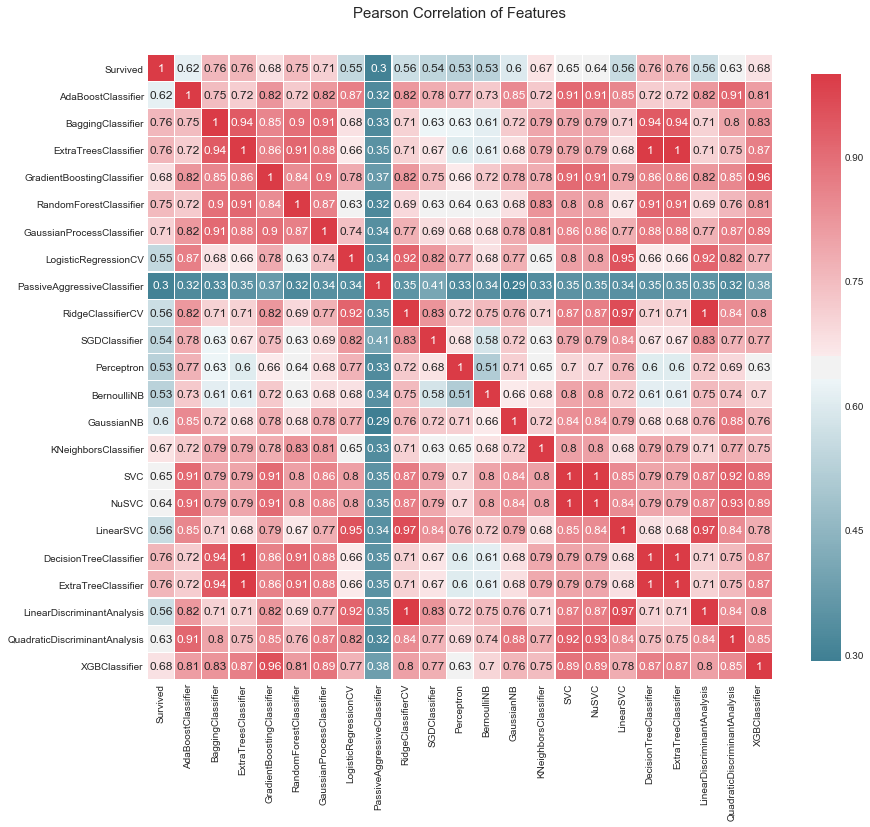

In [42]:
correlation_heatmap(MLA_predict)
# the blue and light red models have low corr, can create an ensemble of models 

**Voting Classifier**

Create an ensemble using sklearn's Voting Classifier

In [43]:
# Create the list of models
vote_est = [
    
    # Ensemble methods
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
    
    # Gaussian Processes
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    # General Linear Model
    ('lr', linear_model.LogisticRegressionCV()),
    
    # Naive Bayes
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    # Nearest Neighbour
    ('knn', neighbors.KNeighborsClassifier()),
    
    # SVM
    ('svc', svm.SVC(probability=True)),
    
    # XGBoost
    ('xgb', XGBClassifier())
]

# Create a hard vote ensemble (majority rules)
vote_hard = ensemble.VotingClassifier(vote_est, voting='hard', n_jobs=-1)
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target], cv=cv_split)
vote_hard.fit(data1[data1_x_bin], data1[Target])

# Print out results for vote hard classifier
print('Hard voting training score mean: {:.2f}'.format(vote_hard_cv['train_score'].mean()*100))
print('Hard voting test score mean: {:.2f}'.format(vote_hard_cv['test_score'].mean()*100))
print('Hard voting 3*std: +/- {:.2f}'.format(vote_hard_cv['test_score'].std()*100*3))
print('-'* 60)

# Create a soft vote ensemble (weighted probabilities)
vote_soft = ensemble.VotingClassifier(vote_est, voting='soft', n_jobs=-1)
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target], cv= cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target])

# Print out results for soft voting classifer
print('Soft voting training score mean: {:.2f}'.format(vote_soft_cv['train_score'].mean()*100))
print('Soft voting test score mean: {:.2f}'.format(vote_soft_cv['test_score'].mean()*100))
print('Soft voting 3*std: +/- {:.2f}'.format(vote_soft_cv['test_score'].std()*100*3))

Hard voting training score mean: 86.57
Hard voting test score mean: 82.20
Hard voting 3*std: +/- 5.11
------------------------------------------------------------
Soft voting training score mean: 87.23
Soft voting test score mean: 82.39
Soft voting 3*std: +/- 3.60


**Tune Voting Classifier**

In [44]:
# Warning, running is computationally expensive

grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_param = [
    # Adaboost Classifier
    [{
        'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
    }],
    
    # Bagging Classifier
    [{'n_estimators': grid_n_estimator,
      'max_samples': grid_ratio,
      'random_state': grid_seed
    }],
    
    # ExtraTreesClassifier
    [{'n_estimators': grid_n_estimator,
      'criterion': grid_criterion,
      'max_depth': grid_max_depth,
      'random_state': grid_seed
    }],
    
    # GradientBoostingClassifier
    [{'learning_rate': grid_learn,
      'n_estimators': grid_n_estimator,
      'max_depth': grid_max_depth,
      'random_state': grid_seed
    }],
    
    # RandomForestClassifier
    [{'n_estimators': grid_n_estimator,
      'criterion': grid_criterion,
      'max_depth': grid_max_depth,
      'oob_score': [True],
      'random_state': grid_seed
    }],
    
    # GaussianProcessClassifier
    [{'max_iter_predict': grid_n_estimator,
    'random_state': grid_seed
     }],
    
    # Logistic Regression
    [{'fit_intercept': grid_bool,
      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
      'random_state': grid_seed
    }],
    
    # BernoulliNB
    [{'alpha': grid_ratio
    }],
    
    # GaussianNB
    [{}],
    
    # K Nearest Neighbours
    [{'n_neighbors': [1,2,3,4,5,6,7],
      'weights': ['uniform', 'distance'],
      'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }],
    
    # SVM
    [{'C': [1,2,3,4,5],
      'gamma': grid_ratio,
      'decision_function_shape': ['ovo', 'ovr'],
      'probability': [True],
      'random_state': grid_seed
    }],
    
    #XGBoost
    [{'learning_rate': grid_learn,
      'max_depth': [1,2,4,6,8,10],
      'n_estimators': grid_n_estimator,
      'seed': grid_seed
    }]
]


start_total = time.perf_counter()
for clf, param in zip(vote_est, grid_param):
    
    start = time.perf_counter()
    best_search = model_selection.GridSearchCV(estimator=clf[1], param_grid=param, cv=cv_split, scoring='roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target])
    run = time.perf_counter() - start
    
    best_param = best_search.best_params_
    print('The best parameter for {} is {}, runtime: {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param)
    
run_total = time.perf_counter() - start_total
print('Total optimization time is {:.2f} minutes'.format(run_total/60))
print('-'*60)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0}, runtime: 40.52 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0}, runtime: 36.74 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0}, runtime: 80.67 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0}, runtime: 348.83 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0}, runtime: 97.66 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0}, runtime: 10.26 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'random_state': 0, 'solver': 'liblinear'}, runtime: 10.03 

In [45]:
# Create a hard vote ensemble (majority rules)
grid_hard = ensemble.VotingClassifier(vote_est, voting='hard', n_jobs=-1)
grid_hard_cv = model_selection.cross_validate(grid_hard, data1[data1_x_bin], data1[Target], cv=cv_split)
grid_hard.fit(data1[data1_x_bin], data1[Target])

# Print out results for vote hard classifier
print('Hard voting (tuned hyperparameters) training score mean: {:.2f}'.format(grid_hard_cv['train_score'].mean()*100))
print('Hard voting (tuned hyperparameters) test score mean: {:.2f}'.format(grid_hard_cv['test_score'].mean()*100))
print('Hard voting (tuned hyperparameters) 3*std: +/- {:.2f}'.format(grid_hard_cv['test_score'].std()*100*3))
print('-'* 60)

# Create a soft vote ensemble (weighted probabilities)
grid_soft = ensemble.VotingClassifier(vote_est, voting='soft', n_jobs=-1)
grid_soft_cv = model_selection.cross_validate(grid_soft, data1[data1_x_bin], data1[Target], cv= cv_split)
grid_soft.fit(data1[data1_x_bin], data1[Target])

# Print out results for soft voting classifer
print('Soft voting (tuned hyperparameters) training score mean: {:.2f}'.format(grid_soft_cv['train_score'].mean()*100))
print('Soft voting (tuned hyperparameters) test score mean: {:.2f}'.format(grid_soft_cv['test_score'].mean()*100))
print('Soft voting (tuned hyperparameters) 3*std: +/- {:.2f}'.format(grid_soft_cv['test_score'].std()*100*3))

Hard voting (tuned hyperparameters) training score mean: 85.47
Hard voting (tuned hyperparameters) test score mean: 82.50
Hard voting (tuned hyperparameters) 3*std: +/- 4.60
------------------------------------------------------------
Soft voting (tuned hyperparameters) training score mean: 84.94
Soft voting (tuned hyperparameters) test score mean: 82.20
Soft voting (tuned hyperparameters) 3*std: +/- 5.42


**The tuned hard vote ensemble gives us the best test score of 82.50. Select this model on the data to predict new observations.** 